## SSH amplification everywhere in the domain

The idea is to identify regions of amplification with respect to the signal outside the bay (mustard station). We will measure the amplification of the signals at the Southern California Bight with respect to the amplitudes exhibited at the northern Baja California coast. We will split the signals into barotropic and baroclinic components.

Here we subtract the signal from the barotropic run (07, uniform density, no stratification) from the base runs (Feb and Aug).

In [1]:
from netCDF4 import Dataset
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
%matplotlib inline
import MITgcmutils as mit
import numpy as np
from scipy import signal
import seaborn as sns
import sys
sys.path.append('/Users/Karina/Research/SVB/notebooks_SVB/')
import svb_tools as svb
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [11]:
def plot_amplification_domain_diff(outdir,outdir2,tt,lat_st,lon_st,ax1,title='',plot_fld='diff',
                                   tini=0,tend=-1,cmap=cmo.cm.curl,vmin=-10, vmax=11):
    
    levs = np.linspace(vmin, vmax, 21)
    eta = mit.mnc.mnc_files(outdir+'eta.0000000000.t*.nc', layout='exch2')
    eta2 = mit.mnc.mnc_files(outdir2+'eta.0000000000.t*.nc', layout='exch2')
    
    if plot_fld=='diff':
        eta_filt4 = (np.squeeze(eta.variables['ETAN'][:,:,lat_st,lon_st])*100-
                 np.squeeze(eta2.variables['ETAN'][:,:,lat_st,lon_st])*100)
        max_ind4 = np.argmax(eta_filt4[tini:tend])
        max_ssh4 = np.max(eta_filt4[tini:tend])  
        eta_filt = (np.squeeze(eta.variables['ETAN'][tt,...])*100-
                    np.squeeze(eta2.variables['ETAN'][tt,...])*100)        
    elif plot_fld=='1':
        eta_filt4 = np.squeeze(eta.variables['ETAN'][:,:,lat_st,lon_st])*100
        max_ind4 = np.argmax(eta_filt4[tini:tend])
        max_ssh4 = np.max(eta_filt4[tini:tend])
        eta_filt = np.squeeze(eta.variables['ETAN'][tt,...])*100
    elif plot_fld=='2':
        eta_filt4 = np.squeeze(eta2.variables['ETAN'][:,:,lat_st,lon_st])*100
        max_ind4 = np.argmax(eta_filt4[tini:tend])
        max_ssh4 = np.max(eta_filt4[tini:tend])
        eta_filt = np.squeeze(eta2.variables['ETAN'][tt,...])*100
    else:
        raise Exception("Invalid option, only diff, 1 or 2 are allowed.") 
    eta.close()
    
    
    ax1.set_facecolor('tan')
    pc = ax1.contourf(LON,LAT,np.ma.masked_array(eta_filt/max_ssh4, mask=mask[0,...]),
                      levels=levs, cmap=cmap, vmin=vmin, vmax=vmax,extend='both')
    plt.colorbar(pc, ax=ax1, label='Amplification')
    #cn = ax1.contour(LON,LAT,np.ma.masked_array(eta_filt/max_ssh4, mask=mask[0,...]),levels=[1], 
    #                 colors=['0.5'])
    cn2 = ax1.contour(LON,LAT,depth, colors=['0','0.3'], levels=[0,250], linewidth=1)
    
    # ssh transects
    for ii, st, col in zip(range(len(lon_inds)),st_model, colors):
        ax1.plot(LON[0,lon_inds[ii]],LAT[lat_inds[ii],0],'o', 
                markersize=8, color=col, markeredgecolor='k')
    ax1.set_ylabel('Lat')
    ax1.set_xlabel('Lon')
    ax1.set_title(title)
    ax1.set_xlim(239-360, 246-360)
    ax1.set_ylim(27,35.3)
    ax1.set_aspect(1)
    
    return(ax1)

def plot_amplification_domain(outdir,outdir2,tt,lat_st,lon_st,fig,ax1,ax2,ax3,
                              tini=0,tend=-1,cmap=cmo.cm.curl,vmin=-10, vmax=11, anim=False):
    
    levs = np.linspace(vmin, vmax, 21)
    eta = mit.mnc.mnc_files(outdir+'eta.0000000000.t*.nc', layout='exch2')
    eta2 = mit.mnc.mnc_files(outdir2+'eta.0000000000.t*.nc', layout='exch2')
    
    eta_filt4_diff = (np.squeeze(eta.variables['ETAN'][:,:,lat_st,lon_st])*100-
                      np.squeeze(eta2.variables['ETAN'][:,:,lat_st,lon_st])*100)
    max_ind4_diff = np.argmax(eta_filt4_diff[tini:tend])
    max_ssh4_diff = np.max(eta_filt4_diff[tini:tend])  
    eta_filt_diff = (np.squeeze(eta.variables['ETAN'][tt,...])*100-
                    np.squeeze(eta2.variables['ETAN'][tt,...])*100)        
    eta_filt4 = np.squeeze(eta.variables['ETAN'][:,:,lat_st,lon_st])*100
    max_ind4 = np.argmax(eta_filt4[tini:tend])
    max_ssh4 = np.max(eta_filt4[tini:tend])
    eta_filt = np.squeeze(eta.variables['ETAN'][tt,...])*100
    
    eta_filt4_2 = np.squeeze(eta2.variables['ETAN'][:,:,lat_st,lon_st])*100
    max_ind4_2 = np.argmax(eta_filt4_2[tini:tend])
    max_ssh4_2 = np.max(eta_filt4_2[tini:tend])
    eta_filt_2 = np.squeeze(eta2.variables['ETAN'][tt,...])*100
      
    ax1.set_facecolor('tan')
    pc = ax1.contourf(LON,LAT,np.ma.masked_array(eta_filt_diff/max_ssh4_diff, mask=mask[0,...]),
                      levels=levs, cmap=cmap, vmin=vmin, vmax=vmax,extend='both')
    cn2 = ax1.contour(LON,LAT,depth, colors=['0','0.3'], levels=[0,250], linewidth=1)
    ax1.plot(LON[0,lon_st], LAT[lat_st,0], 'ko', markeredgecolor='w', markersize=8)
    ax1.set_ylabel('Lat')
    ax1.set_xlabel('Lon')
    ax1.set_xlim(239-360, 246-360)
    ax1.set_ylim(27,35.3)
    ax1.set_title('baroclinic')
    ax1.set_aspect(1)
    
    ax2.set_facecolor('tan')
    pc = ax2.contourf(LON,LAT,np.ma.masked_array(eta_filt_2/max_ssh4_2, mask=mask[0,...]),
                      levels=levs, cmap=cmap, vmin=vmin, vmax=vmax,extend='both')
    cn2 = ax2.contour(LON,LAT,depth, colors=['0','0.3'], levels=[0,250], linewidth=1)
    ax2.plot(LON[0,lon_st], LAT[lat_st,0], 'ko', markeredgecolor='w', markersize=8)
    ax2.set_xlabel('Lon')
    ax2.set_xlim(239-360, 246-360)
    ax2.set_ylim(27,35.3)
    ax2.set_title('barotropic')
    ax2.set_aspect(1)
    
    ax3.set_facecolor('tan')
    pc = ax3.contourf(LON,LAT,np.ma.masked_array(eta_filt/max_ssh4, mask=mask[0,...]),
                      levels=levs, cmap=cmap, vmin=vmin, vmax=vmax,extend='both')
    cn2 = ax3.contour(LON,LAT,depth, colors=['0','0.3'], levels=[0,250], linewidth=1)
    ax3.plot(LON[0,lon_st], LAT[lat_st,0], 'ko', markeredgecolor='w', markersize=8)
    ax3.set_xlabel('Lon')
    ax3.set_xlim(239-360, 246-360)
    ax3.set_ylim(27,35.3)
    ax3.set_title('full')
    ax3.set_aspect(1)
    
    if anim==True:
        if tt==0:
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            cbar_ax = fig.add_axes([0.92, 0.122, 0.022, 0.755])
            cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),extend='both',
                              cax=cbar_ax, orientation='vertical',label='Amplification')
    else:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cbar_ax = fig.add_axes([0.92, 0.122, 0.022, 0.755])
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),extend='both',
                          cax=cbar_ax, orientation='vertical',label='Amplification')
    
    return(ax1,ax2,ax3)

### February reference T and S (horizontally homogeneous density)

In [3]:
outdir = '/Volumes/KYUUBI/SVB/05_448x512x100/04_feb_TSref/mnc_test_0001/'
outdir3 = '/Volumes/KYUUBI/SVB/05_448x512x100/07_barotropic/mnc_test_0001/'

In [4]:
bat = mit.mnc.mnc_files(outdir+'grid.t*.nc', layout='exch2')
depth = bat.variables['Depth'][:]
lat = bat.variables['Y'][:]
lon = bat.variables['X'][:]
LAT = bat.variables['YC'][:]
LON = bat.variables['XC'][:]-360
Z = bat.variables['Z'][:]
Zl = bat.variables['Zl'][:]

# Cell-centers mask
hFacC = bat.variables['HFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)
bat.close()

# Dynamics
dyn = mit.mnc.mnc_files(outdir+'dynVars.0000000000.t*.nc', layout='exch2')
Zind = (dyn.variables['diag_levels'][:]).astype(int)
time = dyn.variables['T'][:]
dyn.close()

### Domain and virtual stations

* Virtual stations try to be as close to the coast as possible (black contour).
* Dark grey contour: 250 m (shelf break)
* Light gray: 500 m

In [5]:
# NOAA stations
lon_noaa = [-(117+15.4/60), -(118+16.4/60), -(118+30.0/60), -(119+41.6/60), -(120+45.3/60)]
lat_noaa = [32+52.0/60, 33+43.2/60, 34+0.5/60,34+24.2/60, 35+10.1/60]
st_noaa  = ['La Jolla', 'Los Angeles', 'Santa Monica', 'Santa Barbara' , 'Port San Luis']

# REDMAR stations
lon_red = [-(116+37.067/60), -(115+58/60+38.95/3600) ]
lat_red = [31+50.894/60, 30+29/60+4.23/3600]
st_red  = ['Ensenada', 'San Quintin']

Depth at station 1: 6.0 m 
Depth at station 2: 4.0 m 
Depth at station 3: 2.0 m 
Depth at station 4: 8.0 m 
Depth at station 5: 2.0 m 
Depth at station 6: 6.0 m 
Depth at station 7: 4.0 m 
Depth at station 8: 6.0 m 
Depth at station 9: 2.0 m 
Depth at station 10: 2.0 m 
Depth at station 11: 2.0 m 
Depth at station 12: 4.0 m 
Depth at station 13: 2.0 m 
Depth at station 14: 4.0 m 


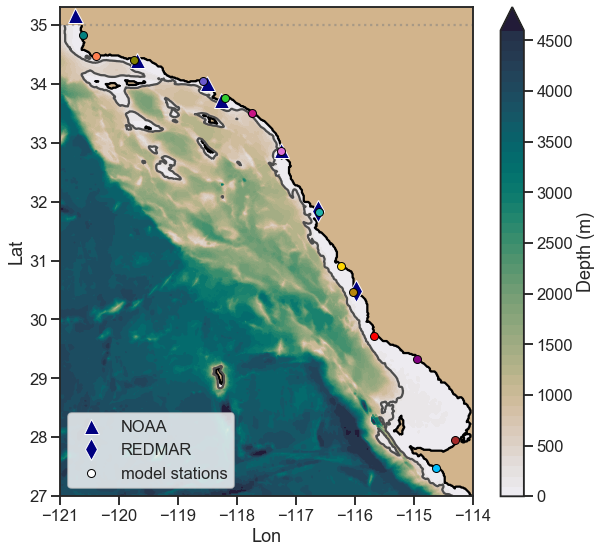

In [6]:
sns.set_style('ticks')
sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')
pc = ax.contourf(LON,LAT,np.ma.masked_array(depth, mask=mask_dep),50,
                 vmin=0, vmax=5000, cmap=cmo.cm.rain, extend='max')
cb = plt.colorbar(pc, extend='max',label='depth / m')
cn = ax.contour(LON,LAT,depth, colors=['0','0.3'], levels=[0,250])
ax.axhline(35, linestyle=':', color='0.5', alpha=0.5)
ax.plot(lon_noaa, lat_noaa, '^',color='navy',markeredgecolor='w', markersize=15)
ax.plot(lon_red, lat_red, 'd',color='navy', markeredgecolor='w', markersize=15)

lon_inds = [408,428,387,340,317,304,280,239,208,155,178,80,38,24]
lat_inds = [30,61,149,174,221,250,308,374,415,450,432,473,477,500]
st_model = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14']
colors = ['deepskyblue','brown','purple','red','darkgoldenrod','gold','lightseagreen',
          'orchid','mediumvioletred', 'slateblue','limegreen','olive','coral','teal']

# ssh transects
for ii, st, col in zip(range(len(lon_inds)),st_model, colors):
    ax.plot(LON[0,lon_inds[ii]],LAT[lat_inds[ii],0],'o', 
            markersize=8, color=col, markeredgecolor='k')
    print('Depth at station %s: %1.1f m ' % (st,depth[lat_inds[ii],lon_inds[ii]]))


cb.set_label('Depth (m)')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim(239-360, 246-360)
ax.set_ylim(27,35.3)
ax.set_aspect(1)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0],linestyle='', markerfacecolor='navy', 
                          marker='^', label='NOAA', markersize=15, markeredgecolor='w'),
                Line2D([0], [0], linestyle='',markerfacecolor='navy', marker='d', label='REDMAR', markersize=15, markeredgecolor='w'),
                Line2D([0], [0], linestyle='',markerfacecolor='w', marker='o', label='model stations', markersize=8, markeredgecolor='k'), 
               ]
ax.legend(handles=legend_elements)


### Amplification

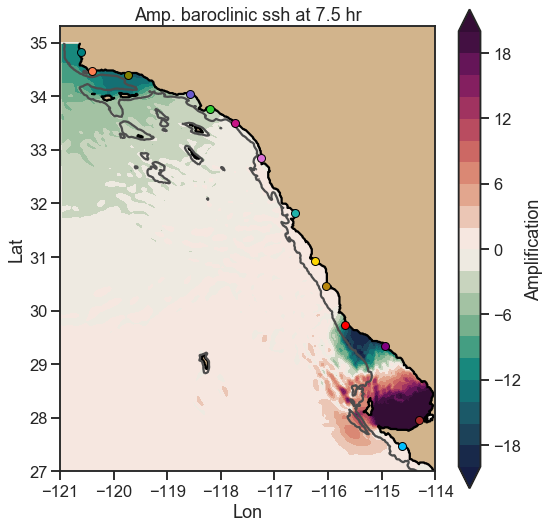

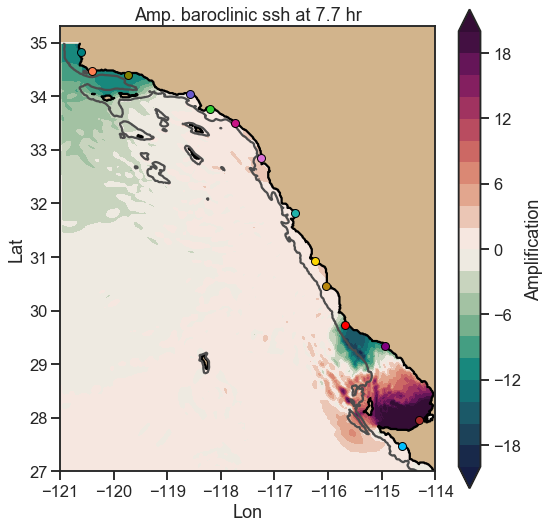

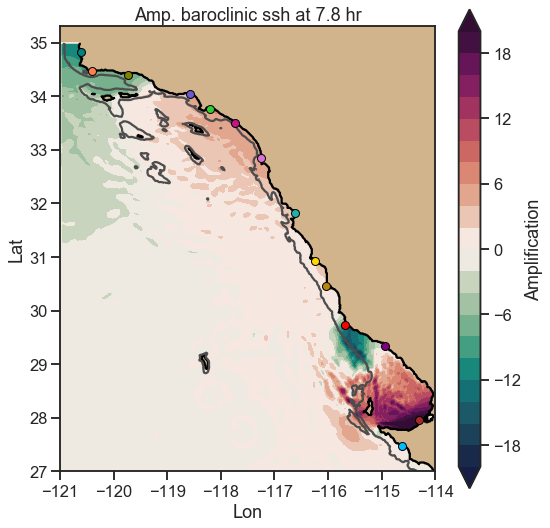

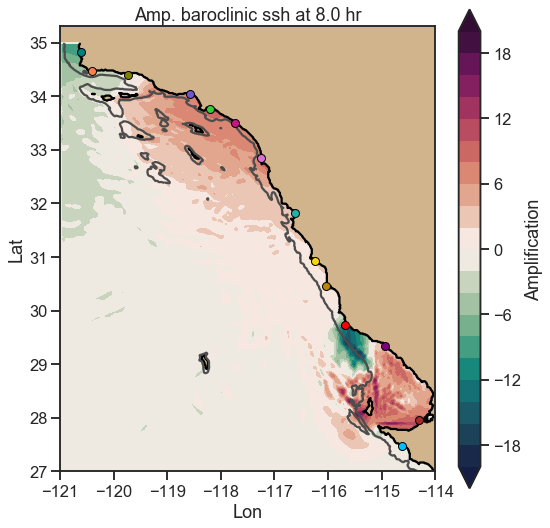

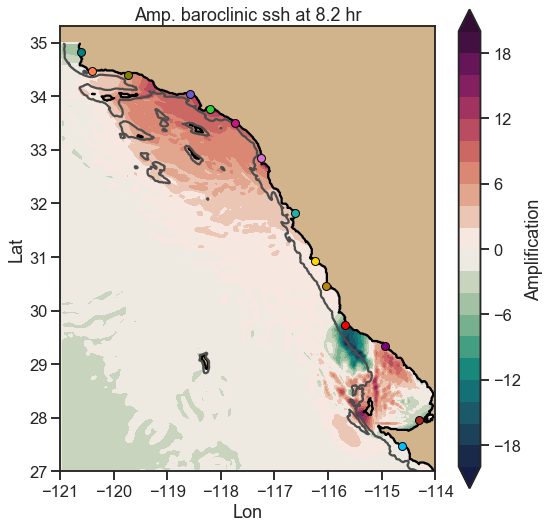

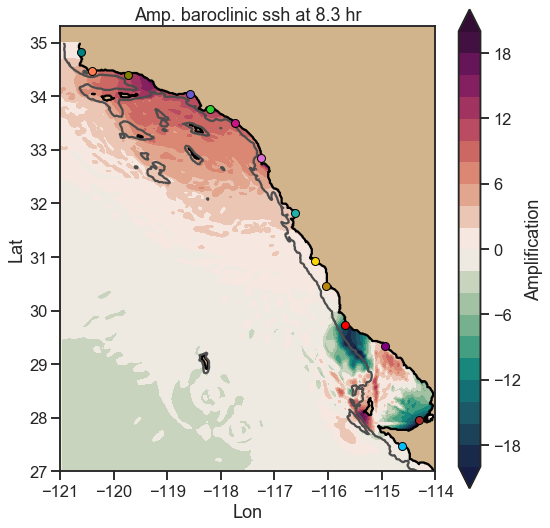

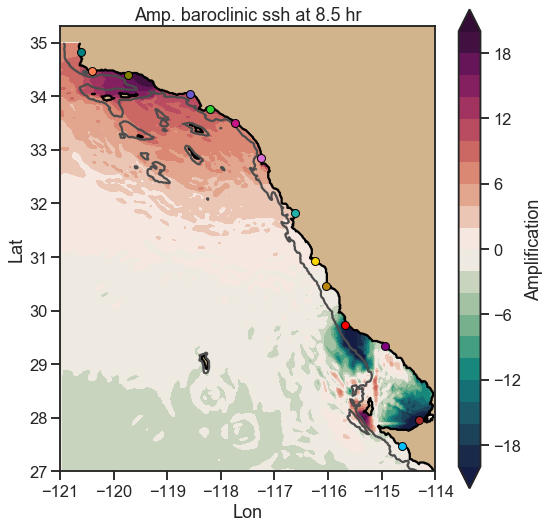

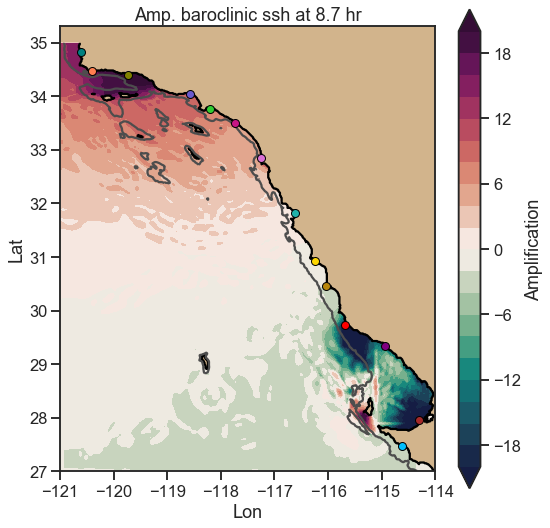

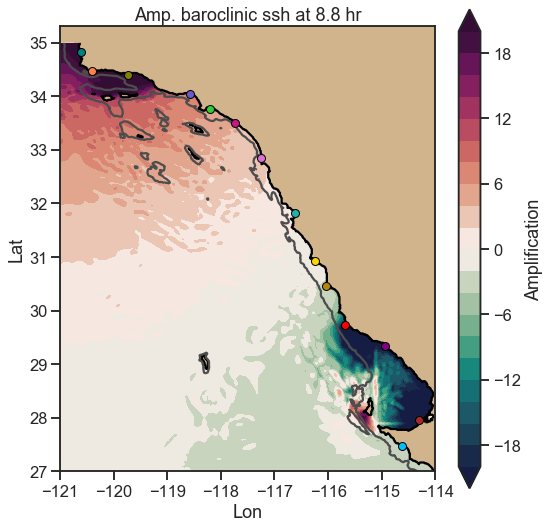

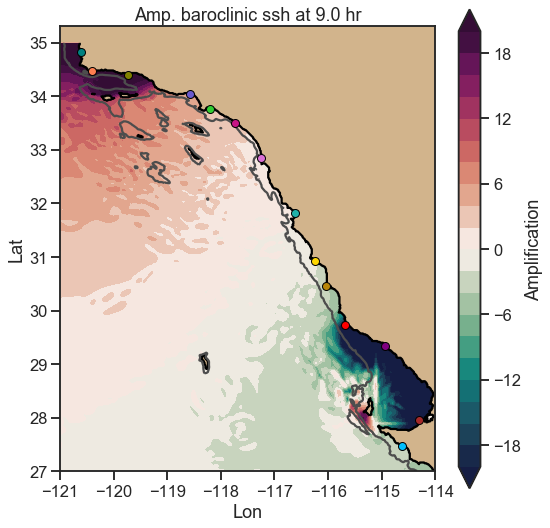

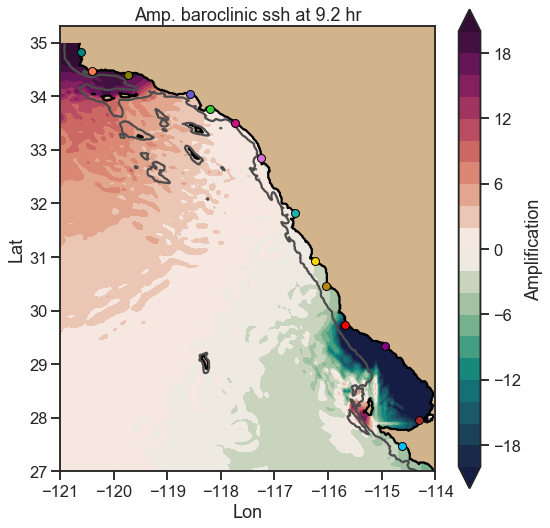

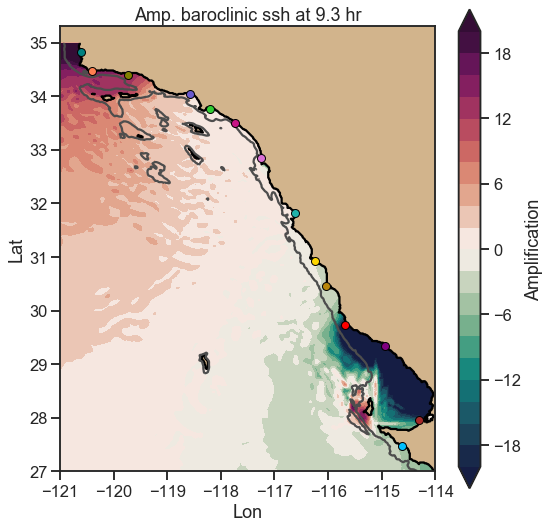

In [26]:
eta = mit.mnc.mnc_files(outdir+'eta.0000000000.t*.nc', layout='exch2')
eta3 = mit.mnc.mnc_files(outdir3+'eta.0000000000.t*.nc', layout='exch2')

tini = 20
tend = 55
lat_st=lat_inds[4]
lon_st=lon_inds[4]

times = [44,45,46,47,48,49,50,51,52,53,54,55]

for tt in times:
    title = 'Amp. baroclinic ssh at %1.1f hr' %(time[tt]/(3600))
    fig = plt.figure(tight_layout=True, figsize=(8,8))
    gs = GridSpec(1, 1)
    ax1 = fig.add_subplot(gs[0])
    ax1 = plot_amplification_domain_diff(outdir,outdir3,tt,lat_st,lon_st,ax1,title=title,plot_fld='diff',
                                         tini=tini,tend=tend,cmap=cmo.cm.curl,vmin=-20, vmax=20)
    plt.show()

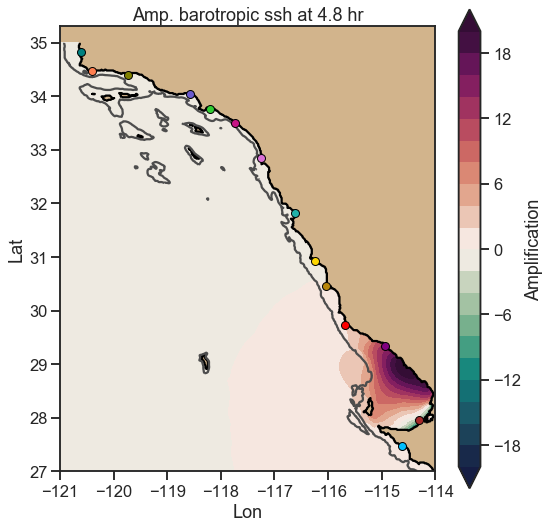

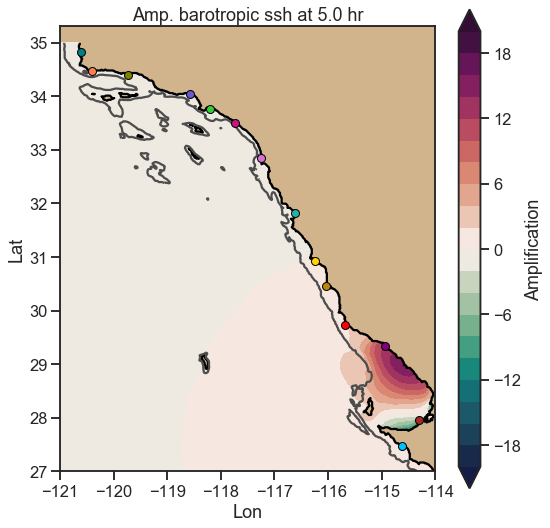

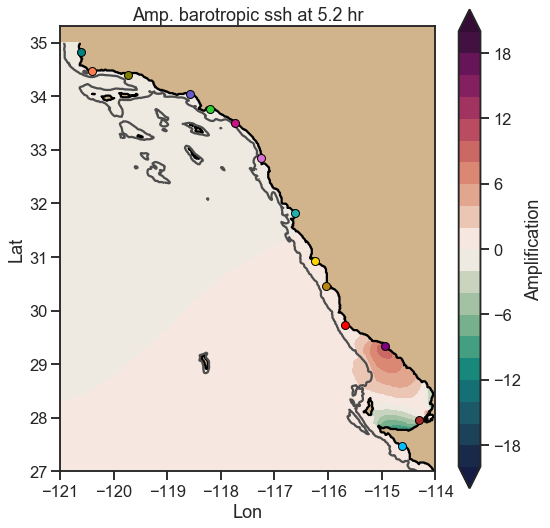

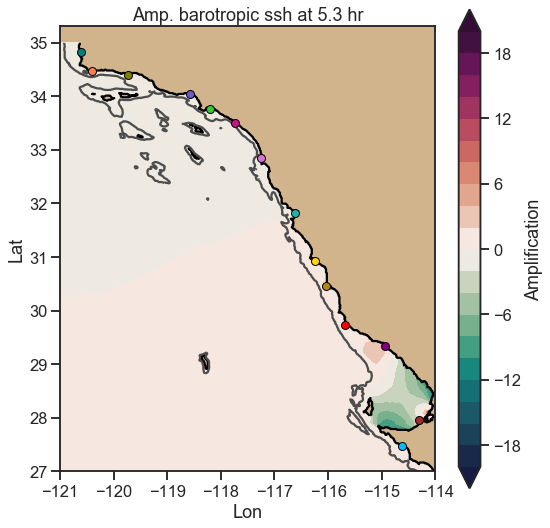

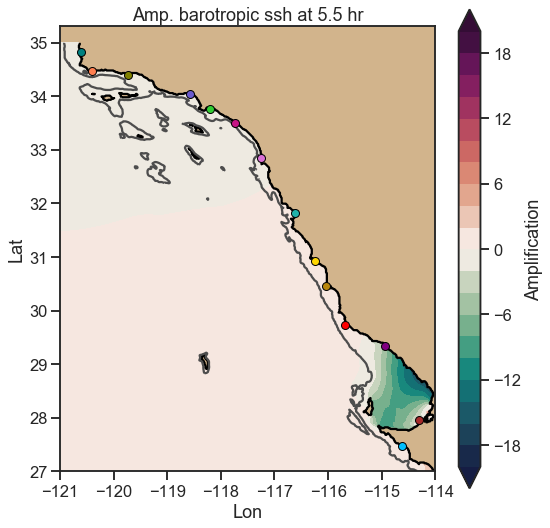

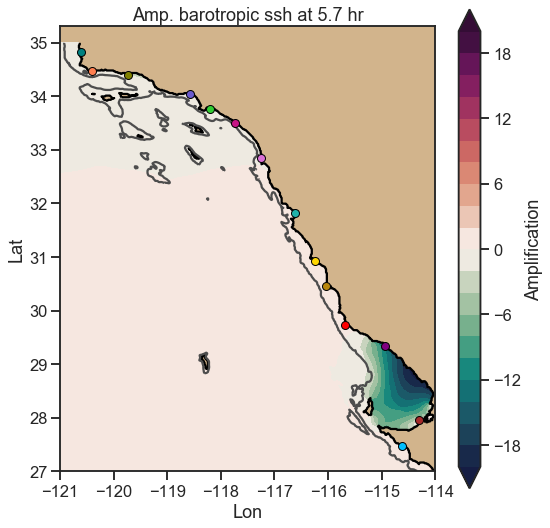

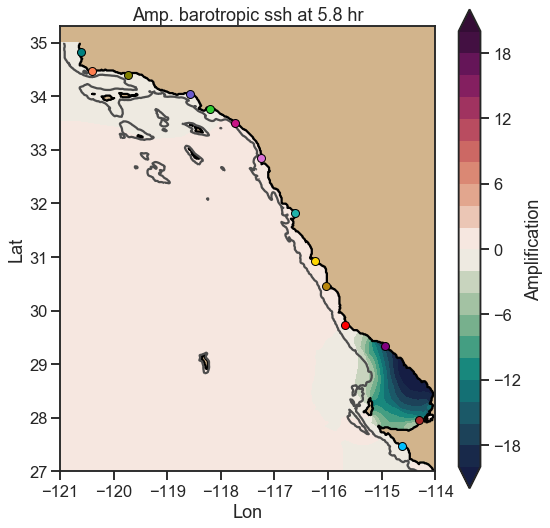

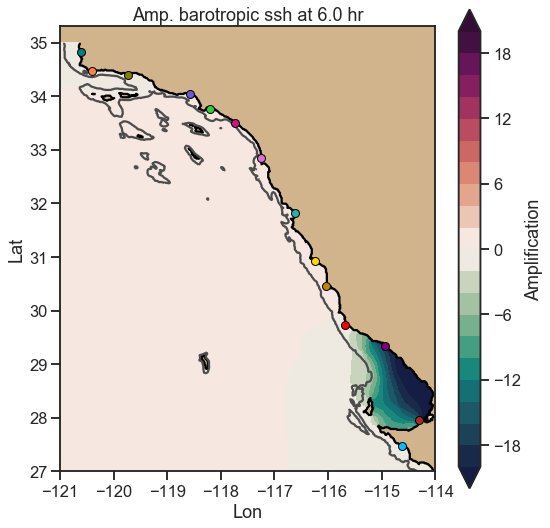

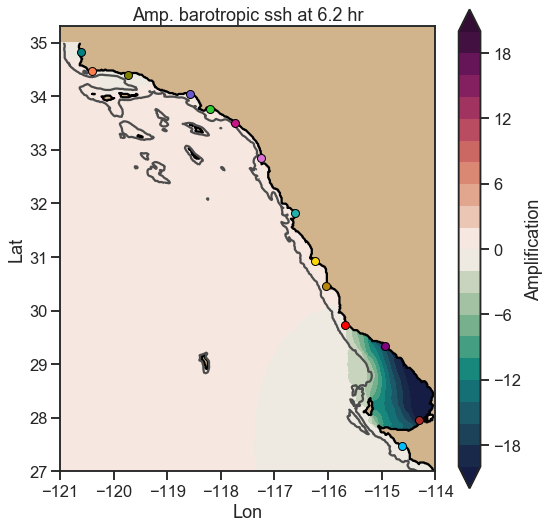

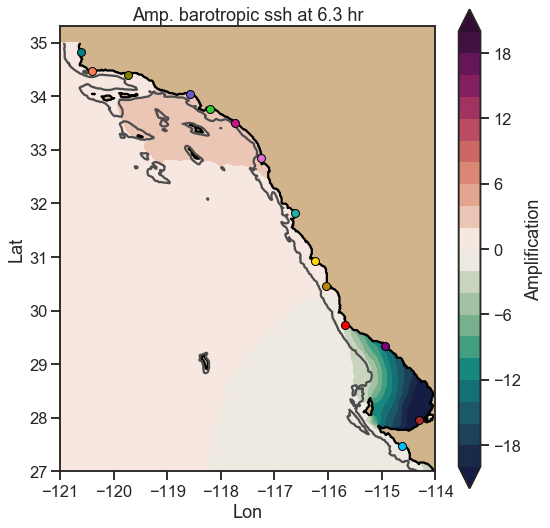

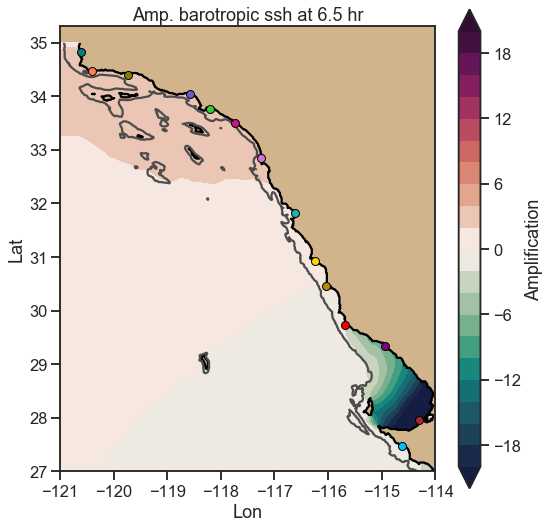

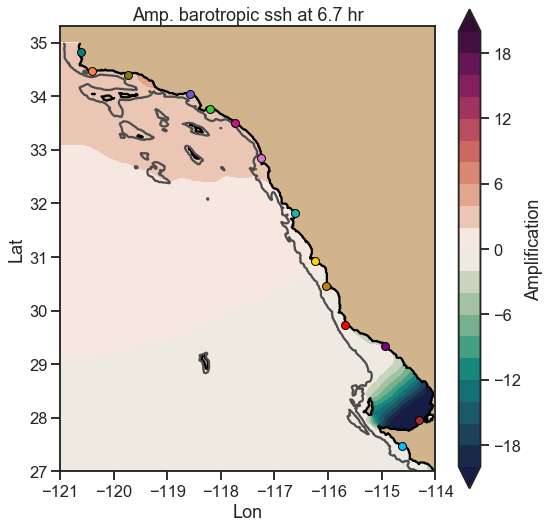

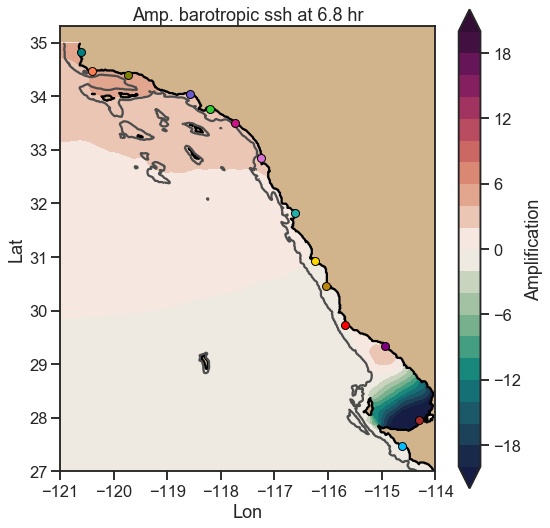

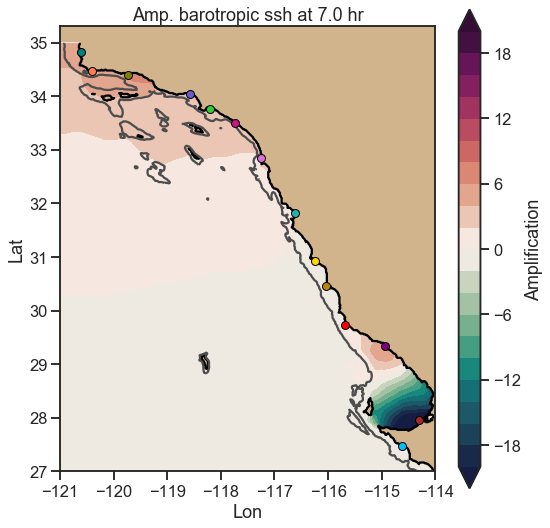

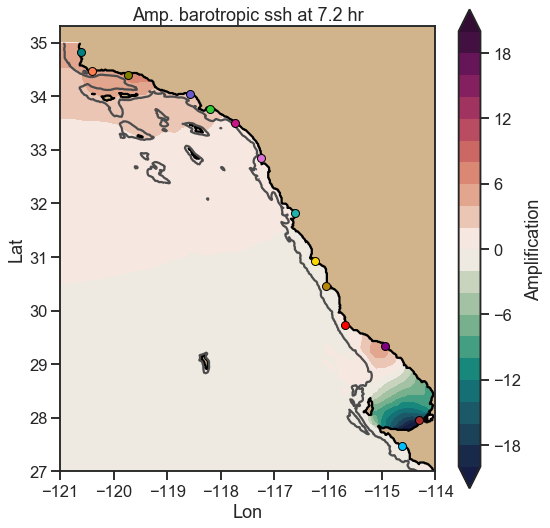

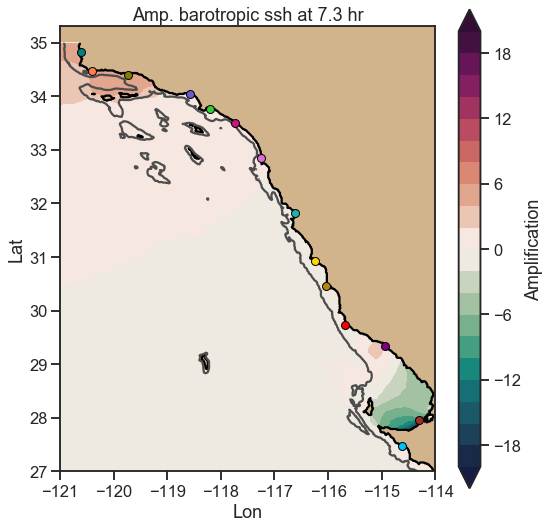

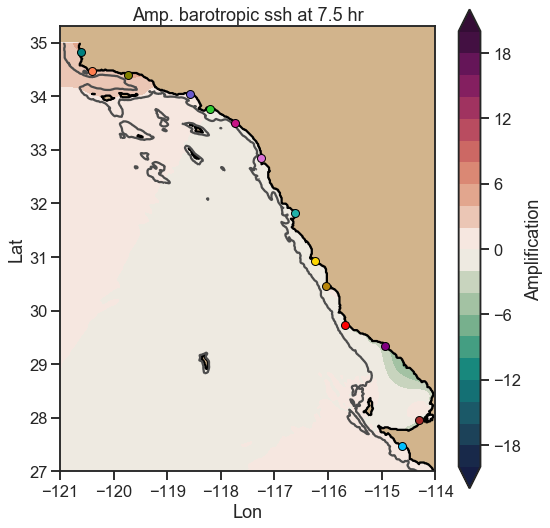

In [33]:
eta = mit.mnc.mnc_files(outdir+'eta.0000000000.t*.nc', layout='exch2')
eta3 = mit.mnc.mnc_files(outdir3+'eta.0000000000.t*.nc', layout='exch2')

tini = 20
tend = 55
lat_st=lat_inds[4]
lon_st=lon_inds[4]

times = [28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44]

for tt in times:
    title = 'Amp. barotropic ssh at %1.1f hr' %(time[tt]/(3600))
    fig = plt.figure(tight_layout=True, figsize=(8,8))
    gs = GridSpec(1, 1)
    ax1 = fig.add_subplot(gs[0])
    ax1 = plot_amplification_domain_diff(outdir,outdir3,tt,lat_st,lon_st,ax1,title=title,plot_fld='1',
                                         tini=tini,tend=tend,cmap=cmo.cm.curl,vmin=-20, vmax=20)
    plt.show()

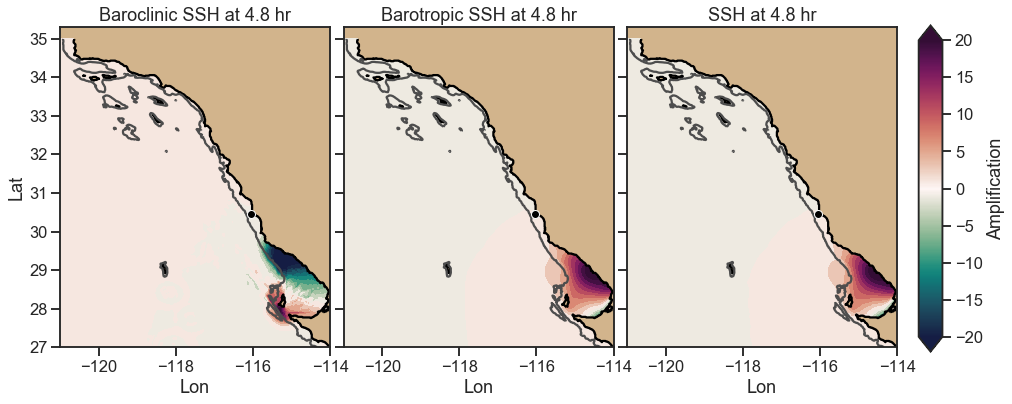

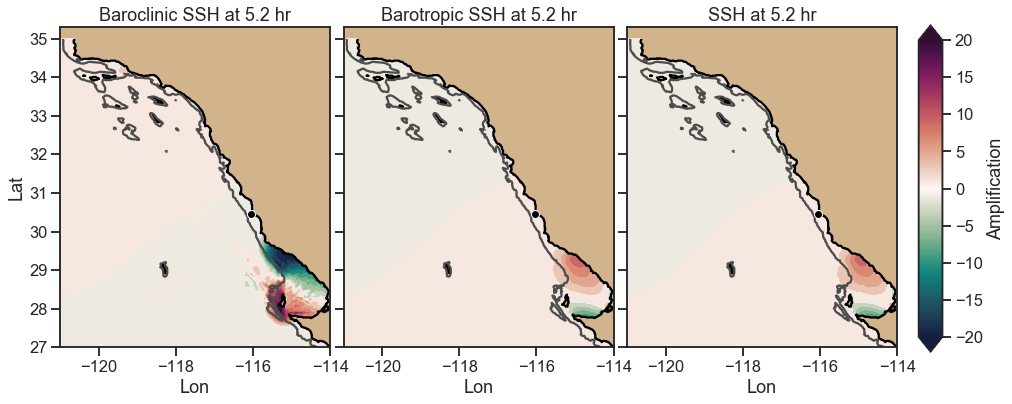

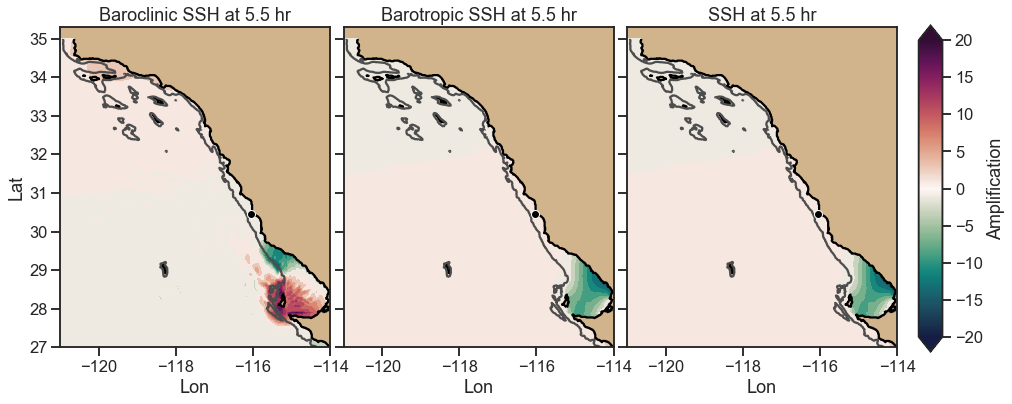

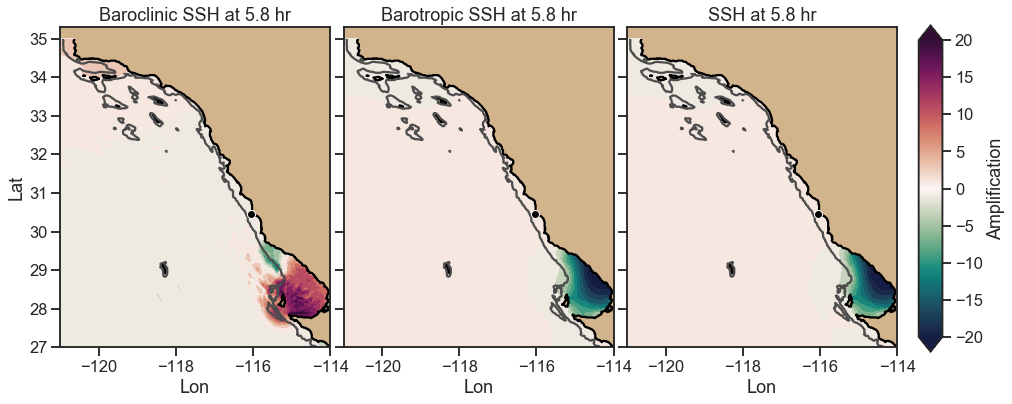

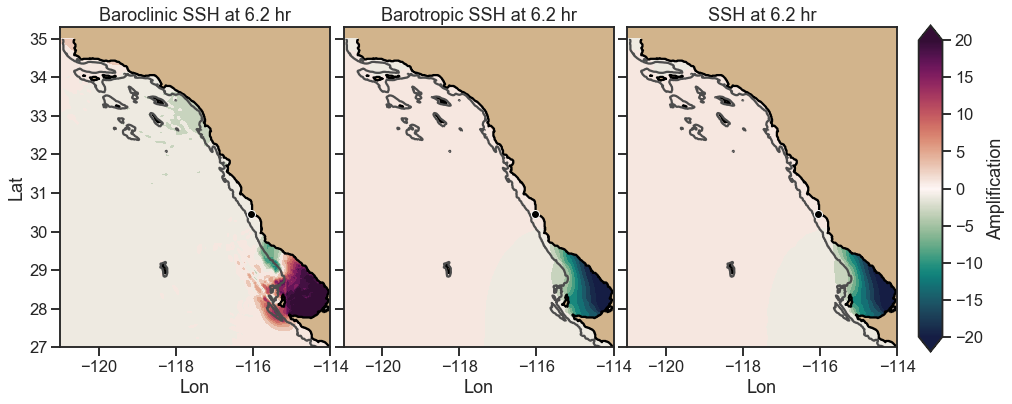

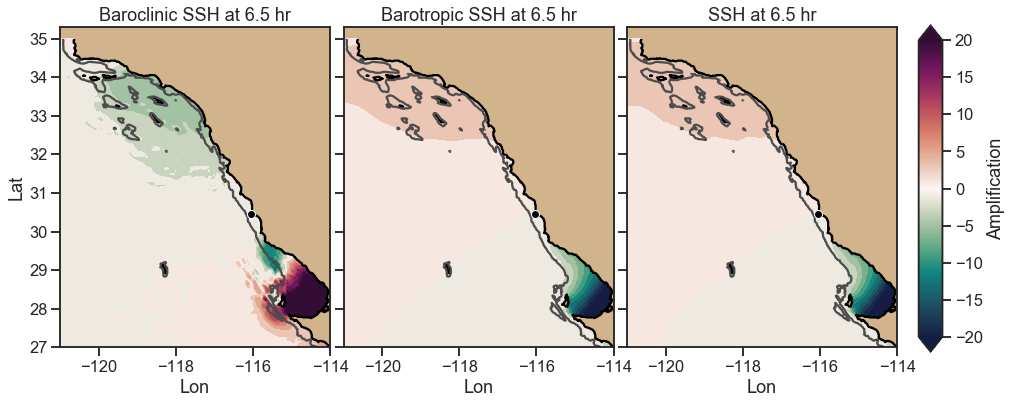

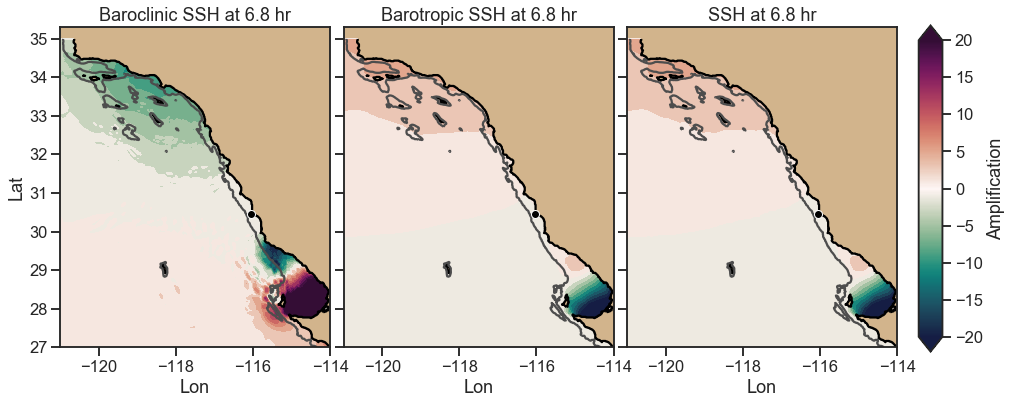

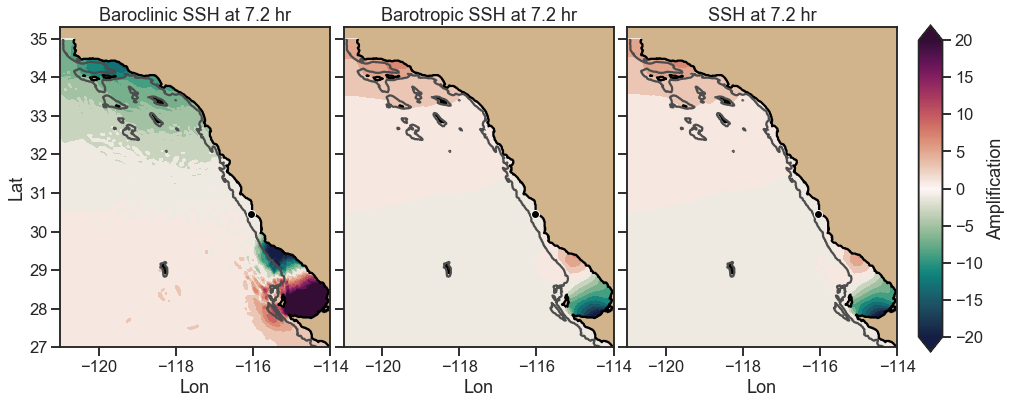

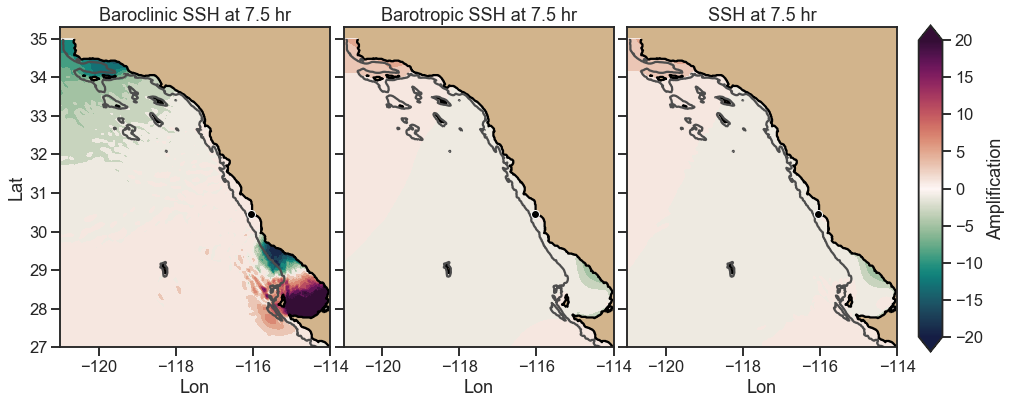

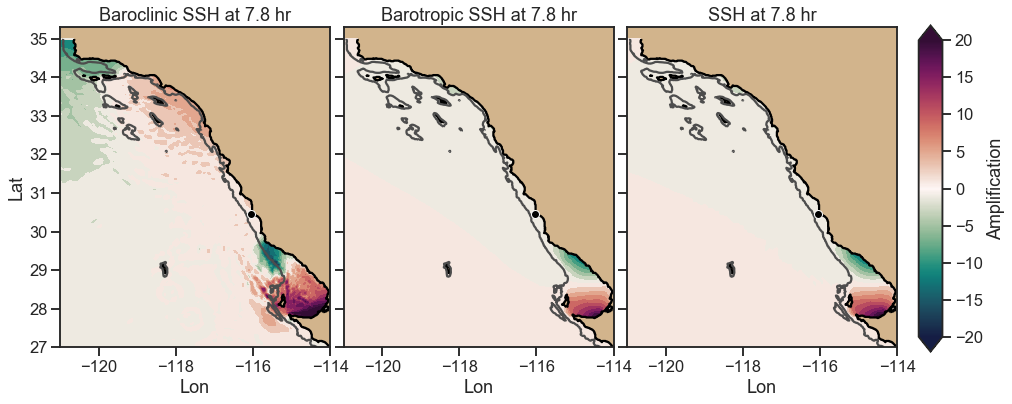

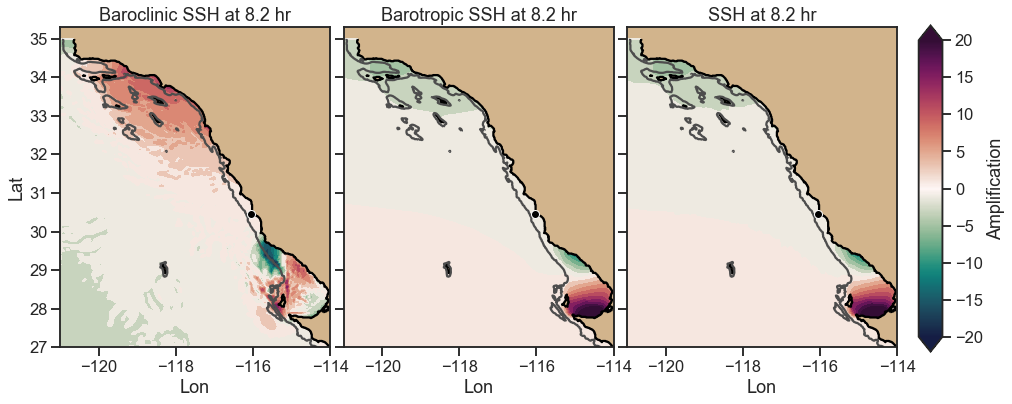

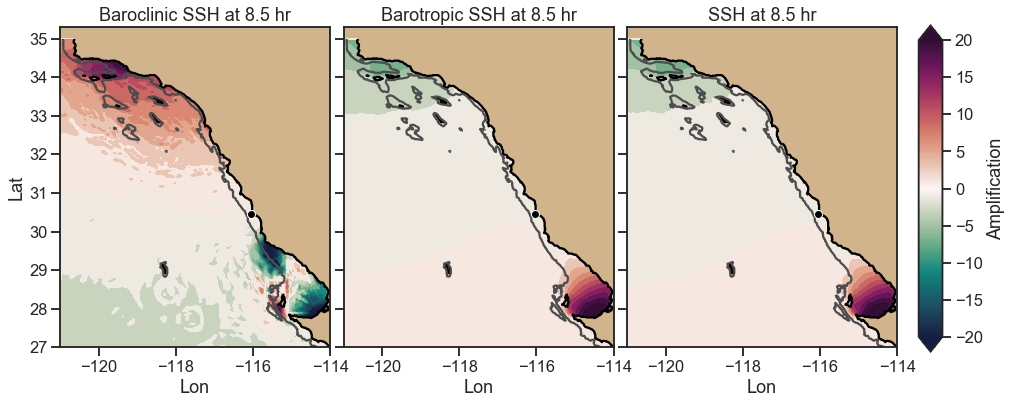

In [35]:
tini = 20
tend = 55
lat_st=lat_inds[4]
lon_st=lon_inds[4]

times = [28,30,32,34,36,38,40,42,44,46,48,50]

for tt in times:
    title1 = 'Baroclinic SSH at %1.1f hr' %(time[tt]/(3600))
    title2 = 'Barotropic SSH at %1.1f hr' %(time[tt]/(3600))
    title3 = 'SSH at %1.1f hr' %(time[tt]/(3600))
    
    fig = plt.figure(tight_layout=True, figsize=(15,6))
    gs = GridSpec(1, 3, wspace=0.05)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], yticklabels=[])
    ax3 = fig.add_subplot(gs[2], yticklabels=[])

    ax1,ax2,ax3 = plot_amplification_domain(outdir,outdir3,tt,lat_st,lon_st,fig,ax1,ax2,ax3,
                                            tini=tini,tend=tend,cmap=cmo.cm.curl,vmin=-20, vmax=20)
    ax1.set_title(title1)
    ax2.set_title(title2)
    ax3.set_title(title3)
    
    plt.show()

    

### Animation

In [101]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

In [106]:
def plot_frame(tt,ax1,ax2,ax3):
    title1 = 'Baroclinic SSH at %1.1f hr' %(time[tt]/(3600))
    title2 = 'Barotropic SSH at %1.1f hr' %(time[tt]/(3600))
    title3 = 'SSH at %1.1f hr' %(time[tt]/(3600))
    
    ax1,ax2,ax3 = plot_amplification_domain(outdir,outdir3,tt,lat_st,lon_st,fig,ax1,ax2,ax3,
                                            tini=tini,tend=tend,cmap=cmo.cm.curl,
                                            vmin=-20, vmax=20, anim=True)
    ax1.set_title(title1)
    ax2.set_title(title2)
    ax3.set_title(title3)

def plot_frame_ini(ax1,ax2,ax3):
    title1 = 'Baroclinic SSH at %1.1f hr' %(time[tt]/(3600))
    title2 = 'Barotropic SSH at %1.1f hr' %(time[tt]/(3600))
    title3 = 'SSH at %1.1f hr' %(time[tt]/(3600))
    
    ax1,ax2,ax3 = plot_amplification_domain(outdir,outdir3,0,lat_st,lon_st,fig,ax1,ax2,ax3,
                                            tini=tini,tend=tend,cmap=cmo.cm.curl,
                                            vmin=-20, vmax=20, anim=True)
    ax1.set_title(title1)
    ax2.set_title(title2)
    ax3.set_title(title3)

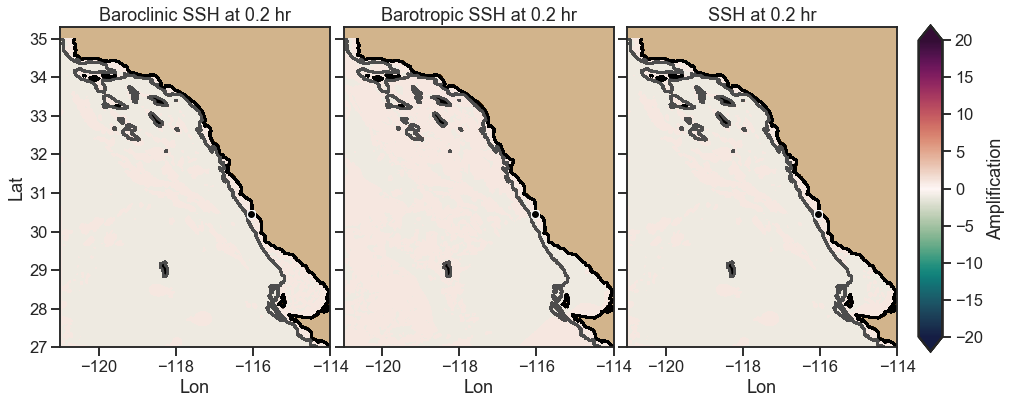

In [134]:
tini = 20
tend = 55
lat_st=lat_inds[4]
lon_st=lon_inds[4]

fig = plt.figure(tight_layout=True, figsize=(15,6))
gs = GridSpec(1, 3, wspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], yticklabels=[])
ax3 = fig.add_subplot(gs[2], yticklabels=[])

# Uncomment lines below to run and save animation
anim = animation.FuncAnimation(fig, plot_frame,init_func=plot_frame_ini(ax1,ax2,ax3),
                               blit=False,fargs=(ax1,ax2,ax3), frames=143, repeat=False)
anim.save('amp_04_febTS.mp4', writer=writer)

